In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split as TTS

import nltk
from nltk.corpus import stopwords
from nltk.corpus import sentiwordnet 
from nltk.corpus import wordnet 
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

import spacy

from typing import List
from pprint import pprint


import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import pyLDAvis.gensim

import tqdm

%matplotlib inline

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marcu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# EDA
### PREPROCESSING

In [32]:
lotr = pd.read_csv("lotr_scripts.csv")
lotr.head()

,Unnamed: 0,char,dialog,movie
0,0,DEAGOL,"Oh Smeagol Ive got one! , Ive got a fish Smeag...",The Return of the King
1,1,SMEAGOL,"Pull it in! Go on, go on, go on, pull it in!",The Return of the King
2,2,DEAGOL,Arrghh!,The Return of the King
3,3,SMEAGOL,Deagol!,The Return of the King
4,4,SMEAGOL,Deagol!,The Return of the King


In [33]:
lotr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2390 entries, 0 to 2389
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  2390 non-null   int64 
 1   char        2390 non-null   object
 2   dialog      2389 non-null   object
 3   movie       2390 non-null   object
dtypes: int64(1), object(3)
memory usage: 74.8+ KB


In [34]:
# Spotting inconcistencies with naming
lotr.char.unique()

array(['DEAGOL', 'SMEAGOL', '(GOLLUM', 'FRODO', 'MERRY', 'GIMLI',
       'GOLLUM', 'SAM', 'GANDALF', 'ARAGORN', 'PIPPIN', 'HOBBIT', 'ROSIE',
       'BILBO', 'TREEBEARD', 'SARUMAN', 'THEODEN', 'GALADRIL', 'ELROND',
       'GRIMA', 'FRODO VOICE OVER', 'WITCH KING', 'EOWYN', 'FARAMIR',
       'ORC', '\xa0GANDALF', 'SOLDIERS ON GATE', 'GOTHMOG', 'GENERAL',
       'CAPTAIN', 'SOLDIER', 'MOUTH OF SAURON', 'EOMER', 'ARMY', 'BOSON',
       'MERCENARY', 'EOWYN/MERRY', 'DENETHOR', 'ROHIRRIM',
       'GALADRIEL VOICEOVER', 'LEGOLAS', 'GALADRIEL', 'KING OF THE DEAD',
       'GRIMBOLD', 'IROLAS', 'ORCS', 'GAMLING', 'MADRIL', 'DAMROD',
       'SOLDIERS', 'SOLDIERS IN MINAS TIRITH', 'GANDALF VOICEOVER',
       'SOLDIER 1', 'SOLDIER 2', 'WOMAN', 'HALDIR', 'SAM VOICEOVER',
       'OLD MAN', 'BOROMIR', 'CROWD', 'ARWEN', 'ELROND VOICEOVER',
       'ARWEN VOICEOVER', 'ARAGORN ', 'HAMA', 'SHARKU', 'PEOPLE', 'LADY',
       'FREDA', 'MORWEN', 'EYE OF SAURON', 'ROHAN STABLEMAN', 'GORBAG',
       'ARGORN', 'GA

In [35]:
flaws = list(["(GOLLUM", "GALADRIL", "FRODO VOICE OVER", "\xa0GANDALF", "MOUTH OF SAURON", "GALADRIEL VOICEOVER", "GANDALF VOICEOVER", 
         "SAM VOICEOVER", "ELROND VOICEOVER", "ARWEN VOICEOVER", "ARAGORN ", "ARGORN", "GANDALF VOICE OVER", "SARUMAN VOICE OVER", 
         "SARUMAN VOICE OVER ", "URUK-HAI" "FRODO ", "GALADRIEL VOICE-OVER", "SAURON VOICE", "SAM ", "FRODO VOICE", 
         "GALADRIEL VOICE OVER", "SARUMAN VOICEOVER", "BILBO VOICEOVER", "GATEKEEPR", "GAN DALF"])

correct = list(["GOLLUM", "GALADRIEL", "FRODO", "GANDALF","SAURON", "GALADRIEL", "GANDALF", "SAM", "ELROND", "ARWEN", "ARAGORN", "ARAGORN", 
                "GANDALF", "SARUMAN", "SARUMAN", "URUK HAI", "FRODO", "GALADRIEL", "SAURON", "SAM", "FRODO", "GALADRIEL", "SARUMAN", 
                "BILBO", "GATEKEEPER", "GANDALF"])

for i in range(len(flaws)):
    lotr.loc[lotr["char"] == flaws[i], "char"] = correct[i]
lotr.char.unique()


array(['DEAGOL', 'SMEAGOL', 'GOLLUM', 'FRODO', 'MERRY', 'GIMLI', 'SAM',
       'GANDALF', 'ARAGORN', 'PIPPIN', 'HOBBIT', 'ROSIE', 'BILBO',
       'TREEBEARD', 'SARUMAN', 'THEODEN', 'GALADRIEL', 'ELROND', 'GRIMA',
       'WITCH KING', 'EOWYN', 'FARAMIR', 'ORC', 'SOLDIERS ON GATE',
       'GOTHMOG', 'GENERAL', 'CAPTAIN', 'SOLDIER', 'SAURON', 'EOMER',
       'ARMY', 'BOSON', 'MERCENARY', 'EOWYN/MERRY', 'DENETHOR',
       'ROHIRRIM', 'LEGOLAS', 'KING OF THE DEAD', 'GRIMBOLD', 'IROLAS',
       'ORCS', 'GAMLING', 'MADRIL', 'DAMROD', 'SOLDIERS',
       'SOLDIERS IN MINAS TIRITH', 'SOLDIER 1', 'SOLDIER 2', 'WOMAN',
       'HALDIR', 'OLD MAN', 'BOROMIR', 'CROWD', 'ARWEN', 'HAMA', 'SHARKU',
       'PEOPLE', 'LADY', 'FREDA', 'MORWEN', 'EYE OF SAURON',
       'ROHAN STABLEMAN', 'GORBAG', 'BOROMIR ', 'UGLUK', 'SHAGRAT',
       'FRODO ', 'URUK-HAI', 'SNAGA', 'GRISHNAKH', 'MERRY and PIPPIN',
       'WILDMAN', 'STRIDER', 'EOTHAIN', 'ROHAN HORSEMAN', 'FARMER MAGGOT',
       'WHITE WIZARD', 'MERRY AND P

In [36]:
lotr['dialog'] = lotr['dialog'].fillna('')
lotr = lotr.drop(["Unnamed: 0", "movie"], axis=1)
lotr.head()

,char,dialog
0,DEAGOL,"Oh Smeagol Ive got one! , Ive got a fish Smeag..."
1,SMEAGOL,"Pull it in! Go on, go on, go on, pull it in!"
2,DEAGOL,Arrghh!
3,SMEAGOL,Deagol!
4,SMEAGOL,Deagol!


In [60]:
# Spørre jake om dette
###########################
lotr_train, lotr_test= TTS(lotr,  test_size=30, random_state=42)

### Initial EDA

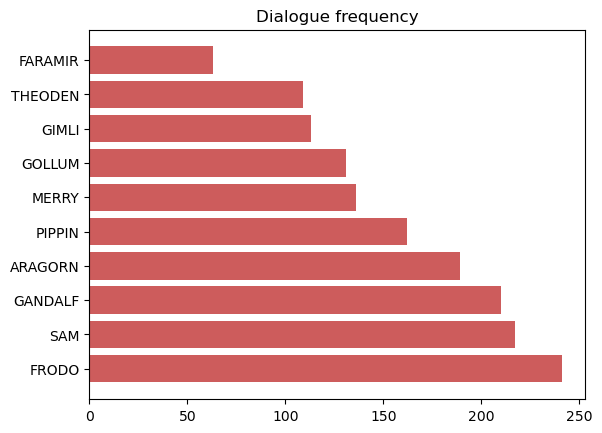

In [38]:
# Plotting dialouge frequnecy
char_freq = lotr_train.groupby("char").size().reset_index(name="freq")
char_freq = char_freq.sort_values(by="freq",ascending=False)
plt.barh(char_freq.char[:10], char_freq.freq[:10], color="indianred")
plt.title("Dialogue frequency")
plt.show()


### SIMPLE FEATURE ENGENERING

In [63]:
stopwords_set = set(stopwords.words("english"))
nlp = spacy.load("en_core_web_sm")

def simple_features(data: pd.DataFrame):
    # dialog lengths
    data["word_len"] = data.dialog.apply(lambda x: len(x.split()))
    data["character_len"] = data.dialog.apply(lambda x: len(x))
    # Stopword count
    data["stopword_count"] = data.dialog.apply(lambda x: sum(1 for word in x.split() if word.lower() in stopwords_set))
    # Word frequency by POS Tag
    data['verb_count'] = data['dialog'].apply(count_verbs)
    data['adj_count'] = data['dialog'].apply(count_adjectives)
    data['propn_count'] = data['dialog'].apply(count_proper_noun)
    # Uniqe word counter
    data['uinque_words'] = data['dialog'].apply(unique_words)

    return data

def count_verbs(text):
    doc = nlp(text)
    return sum(1 for token in doc if token.pos_ == "VERB")

def count_adjectives(text):
    doc = nlp(text)
    return sum(1 for token in doc if token.pos_ == "ADJ")

def count_proper_noun(text):
    doc = nlp(text)
    return sum(1 for token in doc if token.pos_ == "PROPN")

def unique_words(text):
    return len(set(text.split()))

lotr_train = simple_features(lotr_train)
lotr_test = simple_features(lotr_test)

# Ideeas for more #################
# avg. word length
# unique word ratio

ValueError: [E1041] Expected a string, Doc, or bytes as input, but got: <class 'function'>

C:\Users\marcu\AppData\Local\Temp\ipykernel_25800\4054842772.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


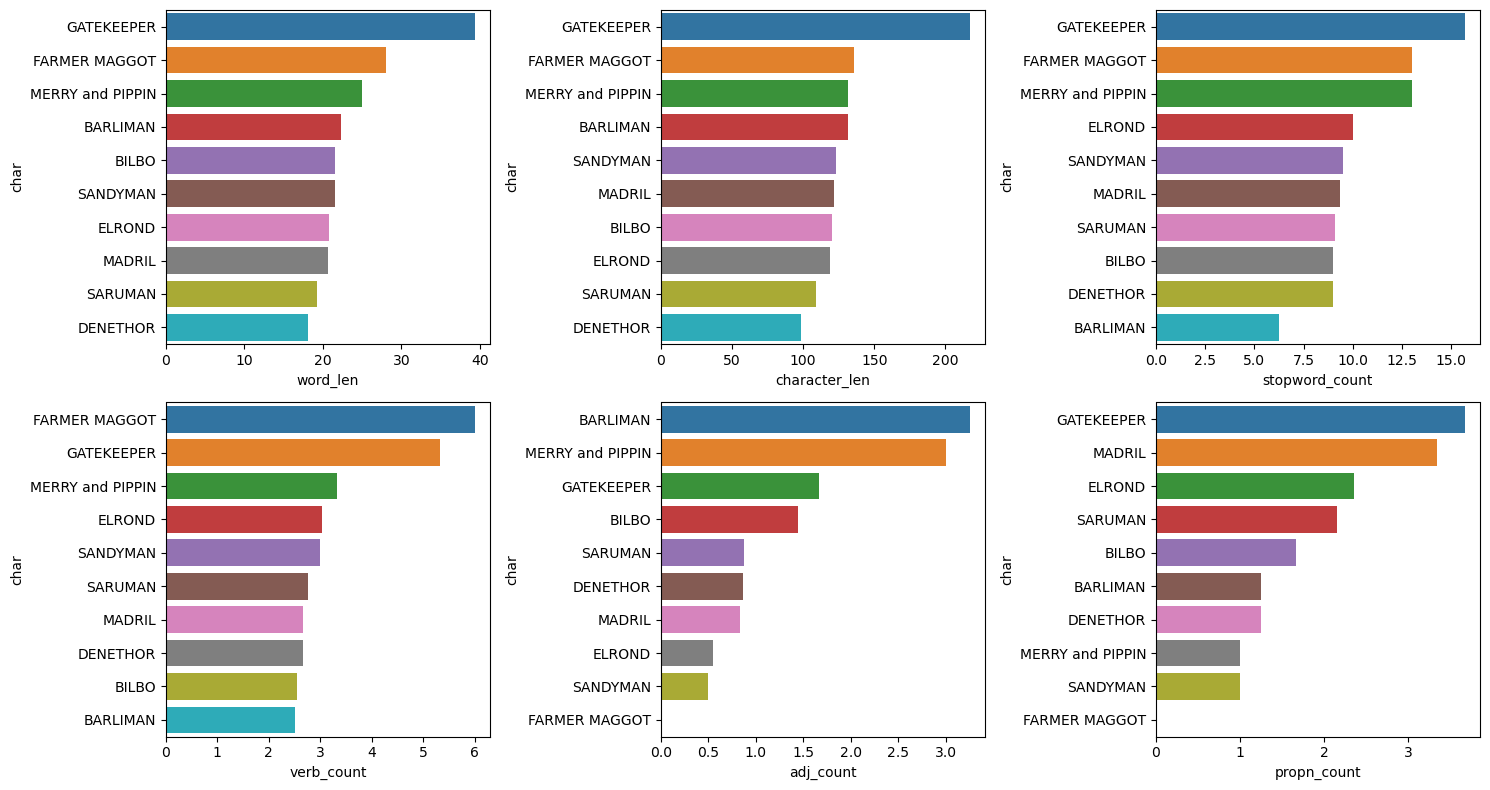

In [40]:
# Plotting dialouge frequnecy
char_var = lotr_train.groupby("char")[["word_len", "character_len", "stopword_count", "verb_count", "adj_count", "propn_count"]].mean().reset_index()
#char_var = char_var.sort_values(by="freq",ascending=False)

plt.figure(figsize = (15, 8))
plt.tight_layout()
plt.subplot(2, 3, 1)
char_var = char_var.sort_values(by="word_len", ascending=False)[:10]
sns.barplot(x=char_var.word_len, y=char_var.char)
plt.subplot(2, 3, 2)
char_var = char_var.sort_values(by="character_len", ascending=False)[:10]
sns.barplot(x=char_var.character_len, y=char_var.char)
plt.subplot(2, 3, 3)
char_var = char_var.sort_values(by="stopword_count", ascending=False)[:10]
sns.barplot(x=char_var.stopword_count, y=char_var.char)
plt.subplot(2, 3, 4)
char_var = char_var.sort_values(by="verb_count", ascending=False)[:10]
sns.barplot(x=char_var.verb_count, y=char_var.char)
plt.subplot(2, 3, 5)
char_var = char_var.sort_values(by="adj_count", ascending=False)[:10]
sns.barplot(x=char_var.adj_count, y=char_var.char)
plt.subplot(2, 3, 6)
char_var = char_var.sort_values(by="propn_count", ascending=False)[:10]
sns.barplot(x=char_var.propn_count, y=char_var.char)
plt.tight_layout()
plt.show()


### SENTIMENT ANALYSIS

In [41]:
# Dialog sentiment

def word_sentiment_score(word: str) -> float:
    synsets = list(sentiwordnet.senti_synsets(word))
    if synsets:
        sentiment = synsets[0]
        return sentiment.pos_score() - sentiment.neg_score()
    else:
        return 0.0  

def sentence_sentiment(sentence):
    sent = nlp(sentence)
    sent_sentiment = sum(word_sentiment_score(token.text) for token in sent)
    return sent_sentiment

def dialog_sentiment(data)
    data['dialog_sentiment'] = data['dialog'].apply(sentence_sentiment)
    return data

lotr_train = dialog_sentiment(lotr_train)
lotr_test = dialog_sentiment(lotr_test)

,char,dialog,word_len,character_len,stopword_count,verb_count,adj_count,propn_count,uinque_words,dialog_sentiment
1503,EOTHAIN,"Yes, Mama.",2,10,0,0,0,1,2,1.125
56,PIPPIN,Hmm?,1,10,0,0,0,1,1,0.000
1208,SAM,"You will not touch him again! , Come on th...",12,62,5,3,0,0,12,-0.250
1372,SARUMAN,The Horse-Men took your lands.They drove your ...,16,98,7,3,0,3,15,-0.625
408,THEODEN,"I have left instruction. , The people are to f...",33,176,15,5,1,3,30,0.000
...,...,...,...,...,...,...,...,...,...,...
1638,GRIMA,"Oh, but you are alone. Who knows what you've s...",57,347,26,7,6,0,49,-0.125
1095,SARUMAN,A new power is rising.Its victory is at hand.,9,46,4,1,1,0,8,1.500
1130,ORC,"Come on then , come on!",6,31,2,2,0,0,6,0.375
1294,SAM,Mr. Frodo!,2,11,0,0,0,2,2,0.000


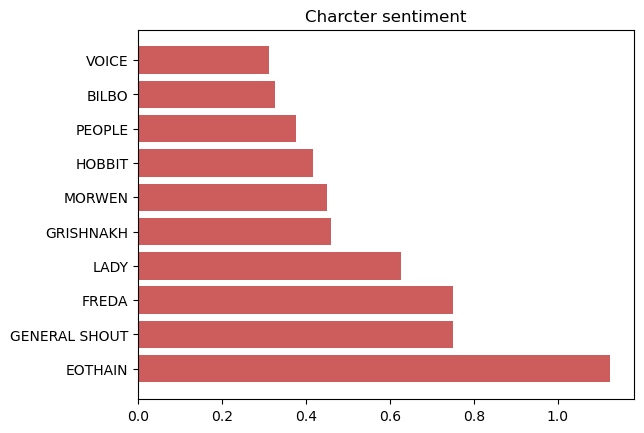

In [42]:
# Plotting dialouge frequnecy
char_sent = lotr_train.groupby("char")["dialog_sentiment"].mean().reset_index()
char_sent = char_sent.sort_values(by="dialog_sentiment", ascending=False)
plt.barh(char_sent.char[:10], char_sent.dialog_sentiment[:10], color="indianred")
plt.title("Charcter sentiment")
plt.show()

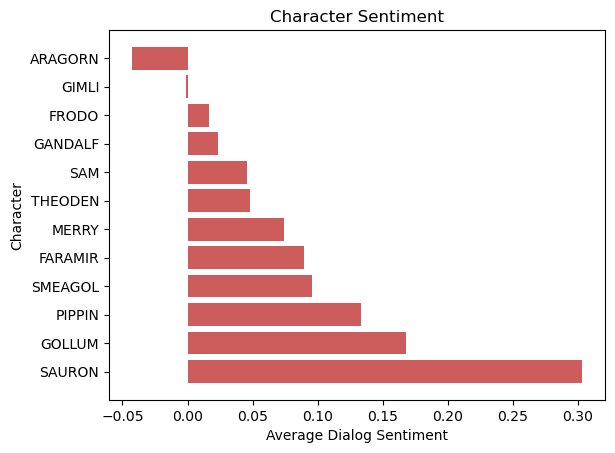

In [43]:
imp_char = ["FRODO", "SAM", "GANDALF", "PIPPIN", "MERRY", "GOLLUM", "GIMLI", "THEODEN", "FARAMIR", "SAURON", "ARAGORN", "SMEAGOL"]
# Plotting dialouge frequnecy
char_sent = lotr_train.groupby("char")["dialog_sentiment"].mean().reset_index()
char_sent = char_sent.sort_values(by="dialog_sentiment", ascending=False)
char_sent_filtered = char_sent[char_sent['char'].isin(imp_char)]
plt.barh(char_sent_filtered['char'], char_sent_filtered['dialog_sentiment'], color="indianred")
plt.title("Character Sentiment")
plt.xlabel("Average Dialog Sentiment")
plt.ylabel("Character")
plt.show()

### LDA - Topic Analysis

In [44]:
# Topic modelling using LDA

stemmer = SnowballStemmer("english")


def stem(text):
    return stemmer.stem(text)

def preprocess_for_topic(document: str) -> List[str]:

    #tokenized = nlp(document)

    preprocessed = []
    for token in gensim.utils.simple_preprocess(document, min_len=4):
        if token not in stopwords_set: #and len(token) > 3:
            preprocessed.append(stem(token.lower()))
    return preprocessed


def create_bow_corp(data):
    preprocessed = []
    [preprocessed.append(preprocess_for_topic(dialog)) for dialog in lotr_train.dialog:]
    dic = corpora.Dictionary(preprocessed)
    bow_corpus = [dic.doc2bow(doc) for doc in preprocessed]
    return preprocessed, dic, bow_corpus

preprocessed_train, dic_train, bow_corpus_train = create_bow_corp(lotr_train)
preprocessed_test, dic_test, bow_corpus_test = create_bow_corp(lotr_test)


lda_model = gensim.models.LdaMulticore(bow_corpus_train, num_topics = 3, id2word = dic_train, passes = 10, workers = 2, random_state=42)
lda_model.show_topics()

[(0,
  '0.032*"frodo" + 0.017*"back" + 0.015*"gandalf" + 0.011*"take" + 0.008*"tree" + 0.008*"hobbit" + 0.008*"precious" + 0.007*"hold" + 0.007*"noth" + 0.007*"good"'),
 (1,
  '0.014*"know" + 0.013*"would" + 0.011*"smeagol" + 0.011*"come" + 0.007*"shall" + 0.007*"dead" + 0.007*"king" + 0.007*"look" + 0.007*"pippin" + 0.006*"gondor"'),
 (2,
  '0.021*"come" + 0.015*"must" + 0.011*"ring" + 0.008*"mordor" + 0.008*"lord" + 0.008*"merri" + 0.007*"sauron" + 0.007*"aragorn" + 0.006*"saruman" + 0.006*"long"')]

In [45]:
# Extract top contributing words for each topic
top_words_per_topic = []
for topic_id in range(lda_model.num_topics):
    topic_words = lda_model.show_topic(topic_id, topn=5)
    top_words = [word for word, _ in topic_words]
    top_words_per_topic.append(top_words)


for i, words in enumerate(top_words_per_topic):
    print(f"Topic {i}: {', '.join(words)}")

Topic 0: frodo, back, gandalf, take, tree
Topic 1: know, would, smeagol, come, shall
Topic 2: come, must, ring, mordor, lord


In [46]:
# Classifying the dialogs to their respective topics
predictions = lda_model[bow_corpus_train]
topic_list = []

for i, pred in enumerate(predictions[:5]):
    max_prob_topic = max(pred, key=lambda x: x[1])
    topic_list.append(max_prob_topic)
    topic_num, prob = max_prob_topic
    topic_keywords = ", ".join([word for word, _ in lda_model.show_topic(topic_num)])
    print(f"Review {i}:")
    print(f"Review body: {lotr_train.dialog[i]}")
    print(f"Predicted Topic: {topic_num}, Confidence: {prob:.4f}")

Review 0:
Review body: Oh Smeagol Ive got one! , Ive got a fish Smeagol, Smeagol!    
Predicted Topic: 2, Confidence: 0.6657
Review 1:
Review body: Pull it in! Go on, go on, go on, pull it in!  
Predicted Topic: 0, Confidence: 0.3333
Review 2:
Review body: Arrghh! 
Predicted Topic: 2, Confidence: 0.6525
Review 3:
Review body: Deagol!  
Predicted Topic: 0, Confidence: 0.7487
Review 4:
Review body: Deagol!  
Predicted Topic: 2, Confidence: 0.8181


In [47]:
# supporting function
def compute_coherence_values(corpus, dictionary, k):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=42,
                                           chunksize=100,
                                           passes=10,)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=preprocessed_train, dictionary=dic_train, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [48]:

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 3
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Validation sets
num_of_docs = len(bow_corpus_train)
corpus_sets = [gensim.utils.ClippedCorpus(bow_corpus_train, int(num_of_docs*0.75)), 
               bow_corpus_train]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # get the coherence score for the given parameters
            cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dic, 
                                                  k=k)
            # Save the model results
            model_results['Validation_Set'].append(corpus_title[i])
            model_results['Topics'].append(k)
            model_results['Coherence'].append(cv)
                    
            pbar.update(1)
    pd.DataFrame(model_results)
    pbar.close()

100%|██████████| 16/16 [17:49<00:00, 66.82s/it]


In [49]:
# Her må du plotte et diagram elns
model_res = pd.DataFrame(model_results)
model_res

,Validation_Set,Topics,Coherence
0,75% Corpus,3,0.379197
1,75% Corpus,4,0.383969
2,75% Corpus,5,0.429866
3,75% Corpus,6,0.416018
4,75% Corpus,7,0.412112
5,75% Corpus,8,0.453733
6,75% Corpus,9,0.421196
7,75% Corpus,10,0.441568
8,100% Corpus,3,0.403145
9,100% Corpus,4,0.364518


In [50]:
lda_model_optimized = gensim.models.LdaMulticore(bow_corpus_train, num_topics = 8, id2word = dic_train, passes = 10, chunksize=100, random_state=42)

# Extract top contributing words for each topic
top_words_per_topic = []
for topic_id in range(lda_model_optimized.num_topics):
    topic_words = lda_model_optimized.show_topic(topic_id, topn=5)
    top_words = [word for word, _ in topic_words]
    top_words_per_topic.append(top_words)


for i, words in enumerate(top_words_per_topic):
    print(f"Topic {i}: {', '.join(words)}")

Topic 0: back, gandalf, hobbit, good, time
Topic 1: smeagol, know, death, hobbit, friend
Topic 2: make, saruman, sorri, rohan, ring
Topic 3: dead, precious, gollum, pippin, could
Topic 4: gondor, would, aragorn, king, lord
Topic 5: must, hold, give, frodo, fight
Topic 6: frodo, master, merri, come, look
Topic 7: come, move, mordor, noth, away


In [51]:
predictions_train = lda_model_optimized[bow_corpus_train]
predictions_test = lda_model_optimized[bow_corpus_test]
topic_list = []

def topic_predictions(bow_data, data):
    predictions = lda_model_optimized[bow_data]
    data["topic"] = [max(pred, key=lambda x: x[1])[0] for pred in predictions]
    return data

print("Teo var her")

lotr_train = 
lotr_data["topic"] = [max(pred, key=lambda x: x[1])[0] for pred in predictions]

In [52]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_optimized, bow_corpus, dictionary=lda_model_optimized.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.016563  0.045639       1        1  16.972834
4      0.107833 -0.018345       2        1  15.071319
2      0.046350 -0.090877       3        1  12.285914
5     -0.007273 -0.122966       4        1  11.811068
7      0.083778  0.004023       5        1  11.543590
1     -0.021886  0.139432       6        1  10.993768
3      0.005875  0.084829       7        1  10.887927
0     -0.198114 -0.041734       8        1  10.433579, topic_info=        Term        Freq       Total Category  logprob  loglift
1       come  137.000000  137.000000  Default  30.0000  30.0000
165    frodo  118.000000  118.000000  Default  29.0000  29.0000
45      back   56.000000   56.000000  Default  28.0000  28.0000
180  smeagol   38.000000   38.000000  Default  27.0000  27.0000
29   gandalf   55.000000   55.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
235    right    6.775919   24.882269   Topic8  -5.0706   0.9594
217     stay    5.763030   14.664068   Topic8  -5.2326   1.3262
26      take    6.656319   57.174299   Topic8  -5.0885   0.1096
290     want    5.984465   33.442774   Topic8  -5.1949   0.5395
165    frodo    6.928684  118.961140   Topic8  -5.0484  -0.5830

[515 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1140      8  0.723884    aaagh
162       5  0.705880     aagh
1580      6  0.695742   afraid
163       1  0.279659    ahead
163       4  0.699146    ahead
...     ...       ...      ...
610       3  0.078888    young
610       4  0.078888    young
610       6  0.078888    young
610       8  0.631102    young
2344      5  0.884736  youwhen

[1107 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 5, 3, 6, 8, 2, 4, 1])

### NRC Sentiment library for more emotions.

In [53]:
file_path = 'NRC-Emotion-Lexicon-Wordlevel-v0.92.txt' # path to downloaded lexicon file

lexicon_emotion = {} # define an empty directory
with open(file_path, 'r', encoding='utf-8') as file:
    for line in file:
        word, emotion, value = line.strip().split('\t')
        if int(value) == 1:
            if word not in lexicon_emotion:
                lexicon_emotion[word] = []
            lexicon_emotion[word].append(emotion) # emotion lexicon as a python dictionart

emotion_list = []


for dialog in lotr_data.dialog:
    token_text = word_tokenize(dialog) # tokenize the text

    cleaned_text = [word for word in token_text if word not in stopwords_set] # remove stopwords
    emotion_counters = {emotion: 0 for emotions in lexicon_emotion.values() for emotion in emotions}
    for token in cleaned_text: # check every word in text
        if token in lexicon_emotion:
            token_emotions = lexicon_emotion[token]
            for emotion in token_emotions:
                emotion_counters[emotion] += 1 # increase emotion values if the word in text is found in lexicon dictionary

    emotion_list.append(emotion_counters)

emotions_df = pd.DataFrame(emotion_list)

# Adding all emotion columns to dataset
lotr_data = pd.concat([lotr_data, emotions_df], axis=1)

emotions_df


,trust,fear,negative,sadness,anger,surprise,positive,disgust,joy,anticipation
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,2,3,2,1,2,0,2,1,0,0
...,...,...,...,...,...,...,...,...,...,...
2355,0,2,4,2,1,1,1,0,0,0
2356,1,0,0,0,0,0,1,0,1,1
2357,0,0,0,0,0,0,0,0,0,0
2358,0,0,0,0,0,0,0,0,0,0


In [54]:
# Function to find the most prominent emotion
def find_prominent_emotion(row):
    max_emotion = row.idxmax()  # Find the column with the maximum value
    max_value = row[max_emotion]  # Get the maximum value
    # Check if there is a single prominent emotion
    if max_value == 0:
        return np.nan # Return 'nan' if there are no prominent emotions
    if row[row == max_value].shape[0] == 1:
        return max_emotion  # Return the most prominent emotion
    else:
        return  

# Apply the function to each row of the DataFrame
lotr_data['emotion'] = emotions_df.apply(find_prominent_emotion, axis=1)

In [55]:
char_emot = lotr_data.groupby('char')[['trust', 'fear', 'negative', 'sadness', 'anger', 'surprise', 'positive', 
                                       'disgust', 'joy', 'anticipation']].sum().reset_index()
char_emot

,char,trust,fear,negative,sadness,anger,surprise,positive,disgust,joy,anticipation
0,ARAGORN,53.0,53.0,68.0,43.0,39.0,24.0,76.0,29.0,30.0,49.0
1,ARMY,2.0,4.0,2.0,1.0,2.0,2.0,4.0,1.0,2.0,1.0
2,ARWEN,5.0,13.0,14.0,5.0,6.0,0.0,10.0,5.0,3.0,8.0
3,BARLIMAN,3.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,2.0,1.0
4,BILBO,5.0,1.0,8.0,3.0,2.0,3.0,10.0,4.0,7.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...
87,VOICE,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
88,WHITE WIZARD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89,WILDMAN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
90,WITCH KING,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,1.0


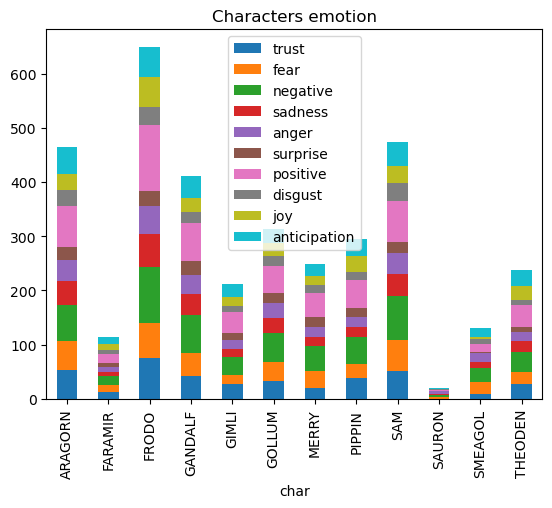

In [56]:

char_emot_filtered = char_emot[char_emot['char'].isin(imp_char)]

char_emot_filtered.plot(x='char', kind='bar', stacked=True,
        title='Characters emotion')
plt.show()

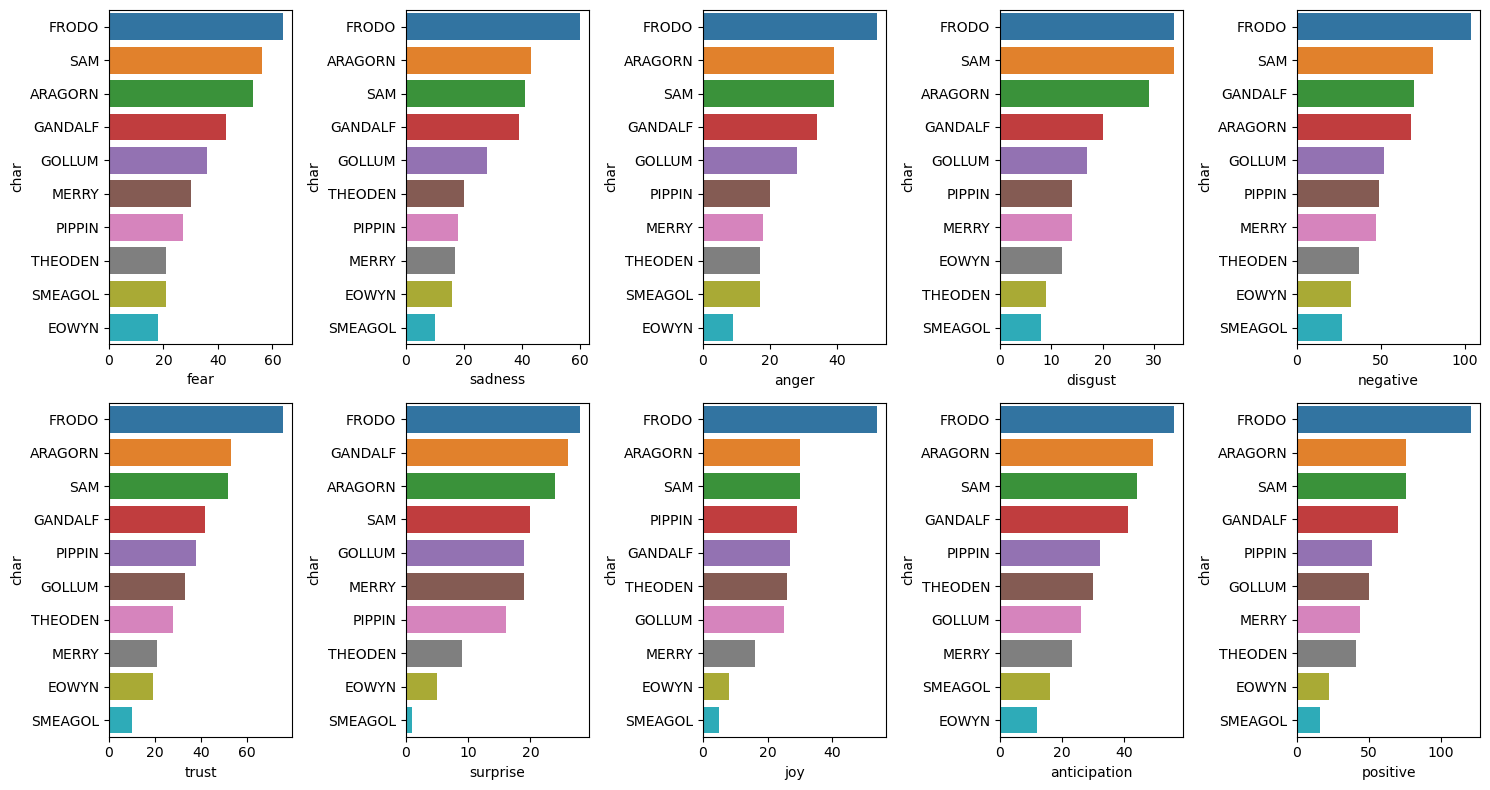

In [57]:
em_list = ['fear',  'sadness', 'anger', 'disgust', 'negative', 
           'trust', 'surprise',  'joy', 'anticipation', 'positive']

def char_emot_subplot(data, x):
    plt.figure(figsize = (15, 8))
    for i in range(1, len(x)+1):
        plt.subplot(2, 5, i)
        data = data.sort_values(by=x[i-1], ascending=False)[:10]
        sns.barplot(x=data[x[i-1]], y=data.char)
    plt.tight_layout()
    plt.show()

char_emot_subplot(char_emot, em_list)

### AVG TF-IDF Score for dialog

In [58]:
def tf(document: List[str], term: str) -> float:

    term_freq = FreqDist()
    for word in document:
        if word.lower() == term:
            term_freq[term] += 1
    
    termfreq = (term_freq[term])/len(document)
    return termfreq


def idf(documents: List[List[str]], term: str) -> float:

    doc_count = 0
    for doc in documents:
        if term in doc:
            doc_count +=1
    if doc_count == 0:
        return 0
    
    idf = np.log(len(documents)/(doc_count))
    return idf


def tf_idf(all_documents: List[List[str]], document: List[str], term: str) -> float:

    term_freq = tf(document, term)
    inverse_df = idf(all_documents, term)
    tf_idf = term_freq*inverse_df

    return tf_idf



dialog_avg_tfidf = []
for dialog in preprocessed:
    score = 0
    for term in dialog:
        p = tf_idf(lotr_data.dialog, dialog, term)
        score += p
    avg_tfidf = score/(len(dialog)+1)
    dialog_avg_tfidf.append(avg_tfidf)
    
lotr_data["avg_tf-idf"] = dialog_avg_tfidf
lotr_data.head()


TypeError: argument of type 'float' is not iterable

## Character prediction
### Divide and conquer

In [ ]:
# Creating a common label for the characters not of interest. 
# Aware that this will impact the model, unsure if it would be positive or negative
mask = lotr["char"].isin(imp_char)
lotr_data2 = lotr.loc[~mask, "char"] = "Rest"
print(lotr_data2["char"].unique())

lotr_y = lotr["char"]
lotr = lotr.drop(["char"], index=1)

lotr_train_X, lotr_train_Y, lotr_test_X, lotr_test_Y = TTS(lotr, lotr_y,  test_size=30, random_state=42)

['Rest' 'SMEAGOL' 'GOLLUM' 'FRODO' 'MERRY' 'GIMLI' 'SAM' 'GANDALF'
 'ARAGORN' 'PIPPIN' 'THEODEN' 'FARAMIR' 'SAURON']


ValueError: Cannot specify both 'labels' and 'index'/'columns'